In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Network:
    def __init__(self, name):
        self.name = name
        self.nodes = {}  # {node_id: set(agent_ids)}
        self.adjacency = {}  # {node_id: [connected_nodes]}
    
    def add_node(self, node_id):
        if node_id not in self.nodes:
            self.nodes[node_id] = set()
            self.adjacency[node_id] = []
    
    def connect_nodes(self, src, dest):
        if src in self.nodes and dest in self.nodes:
            self.adjacency[src].append(dest)
            self.adjacency[dest].append(src)
    
    def add_agent(self, node_id, agent_id):
        if node_id in self.nodes:
            self.nodes[node_id].add(agent_id)
    
    def remove_agent(self, node_id, agent_id):
        if node_id in self.nodes:
            self.nodes[node_id].discard(agent_id)
    
    def get_agents(self, node_id):
        return self.nodes.get(node_id, set())

class Human:
    def __init__(self, uid):
        self.id = uid
        self.state = 'S'  # S, I, R
        self.home = None
        self.work = None
        self.current_location = None
        self.infected_day = -1
        self.age = random.randint(15, 60)
    
    def move(self, new_network, new_node):
        if self.current_location:
            old_net, old_node = self.current_location
            old_net.remove_agent(old_node, self.id)
        new_network.add_agent(new_node, self.id)
        self.current_location = (new_network, new_node)

class Mosquito:
    def __init__(self, uid):
        self.id = uid
        self.state = 'S'  # S, E, I
        self.breeding_site = None
        self.current_location = None
        self.exposed_day = -1
        self.age = random.randint(1, 30)
    
    def move(self, new_network, new_node):
        if self.current_location:
            old_net, old_node = self.current_location
            old_net.remove_agent(old_node, self.id)
        new_network.add_agent(new_node, self.id)
        self.current_location = (new_network, new_node)

class MalariaSimulation:
    def __init__(self, temp=28):
        self.humans = []
        self.mosquitoes = []
        self.day = 0
        self.hour = 0
        
        # Initialize networks
        self.houses = Network("Houses")
        self.workplaces = Network("Workplaces")
        self.breeding_sites = Network("BreedingSites")
        
        # Create network nodes
        for i in range(100): self.houses.add_node(i)
        for i in range(20): self.workplaces.add_node(i)
        for i in range(50): self.breeding_sites.add_node(i)
        
        # Temperature-dependent parameters
        self.a = max(0, 0.017*temp - 0.165)  # Biting rate
        self.b = 0.35  # Human infection prob
        self.c = 0.5   # Mosquito infection prob
        self.r = 0.05  # Human recovery rate
        self.mu_m = 1/(-0.03*(temp**2) + 1.31*temp - 4.4)  # Mosquito mortality
        self.tau_m = int(747.55*np.exp(-0.239*temp) + 5.06)  # Incubation period
        self.mu_h = 0.0002  # Human mortality
        
        # Initialize populations
        self.init_populations()
        
        # Data tracking
        self.history = {
            'S': [], 'I': [], 'R': [],
            'E_mos': [], 'I_mos': [],
            'total': []
        }
    
    def init_populations(self):
        # Create 1000 humans
        for i in range(10000):
            human = Human(i)
            home = random.choice(list(self.houses.nodes.keys()))
            work = random.choice(list(self.workplaces.nodes.keys()))
            human.home = (self.houses, home)
            human.work = (self.workplaces, work)
            human.move(*human.home)
            if i < 10:  # Initial infections
                human.state = 'I'
                human.infected_day = 0
            self.humans.append(human)
        
        # Create 5000 mosquitoes
        for i in range(5000):
            mosquito = Mosquito(1000 + i)
            site = random.choice(list(self.breeding_sites.nodes.keys()))
            mosquito.breeding_site = (self.breeding_sites, site)
            mosquito.move(*mosquito.breeding_site)
            if i < 100:  # Initial infections
                mosquito.state = 'I'
            self.mosquitoes.append(mosquito)
    
    def schedule_movement(self):
        current_hour = self.hour % 24
        for human in self.humans:
            if 8 <= current_hour < 18:  # Work hours
                if human.current_location != human.work:
                    human.move(*human.work)
            else:  # Home hours
                if human.current_location != human.home:
                    human.move(*human.home)
        
        # Mosquitoes move randomly between breeding sites and human locations
        for mosquito in self.mosquitoes:
            if random.random() < 0.1:  # 10% chance to move
                if current_hour > 18 or current_hour < 6:  # Night movement
                    target = random.choice([
                        *self.houses.nodes.keys(),
                        *self.workplaces.nodes.keys()
                    ])
                    net = random.choice([self.houses, self.workplaces])
                else:
                    net = self.breeding_sites
                    target = random.choice(list(net.nodes.keys()))
                mosquito.move(net, target)
    
    def handle_infections(self):
        # Collect all locations with humans
        human_locations = {}
        for human in self.humans:
            net, node = human.current_location
            key = (net.name, node)
            if key not in human_locations:
                human_locations[key] = []
            human_locations[key].append(human)
        
        # Check mosquito-human overlaps
        for mosquito in self.mosquitoes:
            m_net, m_node = mosquito.current_location
            key = (m_net.name, m_node)
            
            if key in human_locations:
                humans = human_locations[key]
                if mosquito.state == 'I' and random.random() < self.a:
                    # Infect humans
                    for human in humans:
                        if human.state == 'S' and random.random() < self.b:
                            human.state = 'I'
                            human.infected_day = self.day
                
                elif mosquito.state == 'S':
                    # Get infected from humans
                    infected_humans = [h for h in humans if h.state == 'I']
                    if infected_humans and random.random() < self.a:
                        if random.random() < self.c:
                            mosquito.state = 'E'
                            mosquito.exposed_day = self.day
    
    def update_states(self):
        # Human recovery and mortality
        new_humans = []
        for human in self.humans:
            # Recovery
            if human.state == 'I' and (self.day - human.infected_day) > 14:
                if random.random() < self.r:
                    human.state = 'R'
            
            # Mortality
            if random.random() < self.mu_h:
                if human.current_location:
                    net, node = human.current_location
                    net.remove_agent(node, human.id)
                continue  # Remove from population
            
            new_humans.append(human)
        self.humans = new_humans
        
        # Mosquito state transitions and mortality
        new_mosquitoes = []
        for mosquito in self.mosquitoes:
            # Incubation
            if mosquito.state == 'E' and (self.day - mosquito.exposed_day) >= self.tau_m:
                mosquito.state = 'I'
            
            # Mortality
            if random.random() < self.mu_m:
                if mosquito.current_location:
                    net, node = mosquito.current_location
                    net.remove_agent(node, mosquito.id)
                continue
            
            new_mosquitoes.append(mosquito)
        
        # Repopulate mosquitoes
        target_count = 5000
        while len(new_mosquitoes) < target_count:
            new_id = 1000 + len(new_mosquitoes)
            mosquito = Mosquito(new_id)
            site = random.choice(list(self.breeding_sites.nodes.keys()))
            mosquito.move(self.breeding_sites, site)
            new_mosquitoes.append(mosquito)
        
        self.mosquitoes = new_mosquitoes
    
    def step(self):
        # Update daily cycle
        for _ in range(24):
            self.schedule_movement()
            self.handle_infections()
            self.hour += 1
        
        self.update_states()
        self.record_stats()
        self.day += 1
    
    def record_stats(self):
        S = sum(1 for h in self.humans if h.state == 'S')
        I = sum(1 for h in self.humans if h.state == 'I')
        R = sum(1 for h in self.humans if h.state == 'R')
        E_mos = sum(1 for m in self.mosquitoes if m.state == 'E')
        I_mos = sum(1 for m in self.mosquitoes if m.state == 'I')
        
        self.history['S'].append(S)
        self.history['I'].append(I)
        self.history['R'].append(R)
        self.history['E_mos'].append(E_mos)
        self.history['I_mos'].append(I_mos)
        self.history['total'].append(len(self.humans))
    
    def plot_results(self):
        days = np.arange(len(self.history['S']))
        
        plt.figure(figsize=(12,6))
        plt.plot(days, self.history['S'], label='Susceptible')
        plt.plot(days, self.history['I'], label='Infected')
        plt.plot(days, self.history['R'], label='Recovered')
        plt.xlabel('Days')
        plt.ylabel('Human Population')
        plt.legend()
        
        plt.twinx()
        plt.plot(days, self.history['E_mos'], '--', label='Exposed Mosquitoes')
        plt.plot(days, self.history['I_mos'], '-.', label='Infectious Mosquitoes')
        plt.ylabel('Mosquito Population')
        plt.legend()
        
        plt.title('Malaria Transmission Dynamics')
        plt.show()

# Run simulation
sim = MalariaSimulation(temp=28)
for _ in range(90):
    sim.step()

sim.plot_results()

AttributeError: 'MalariaSimulation' object has no attribute 'houses'

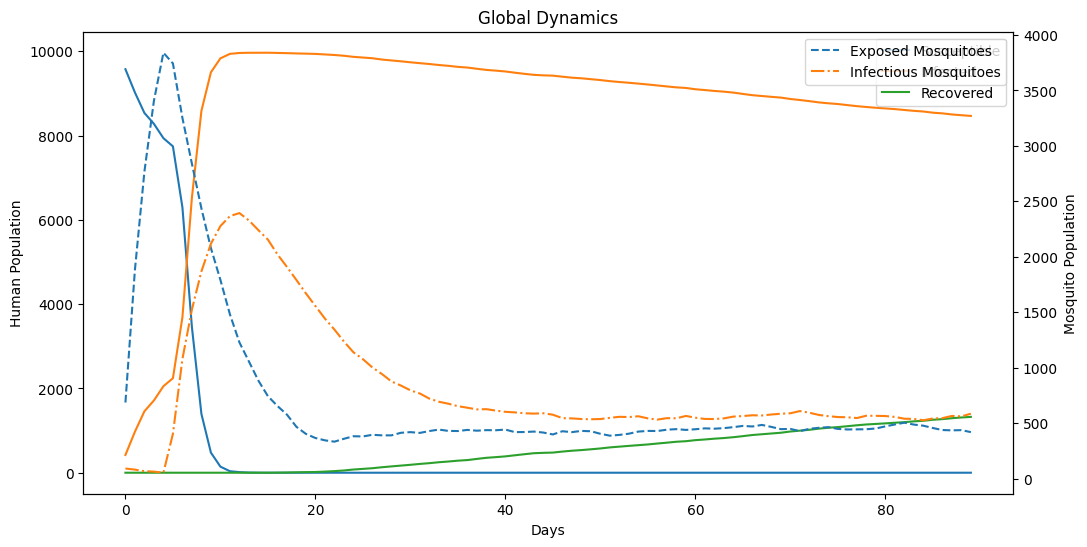

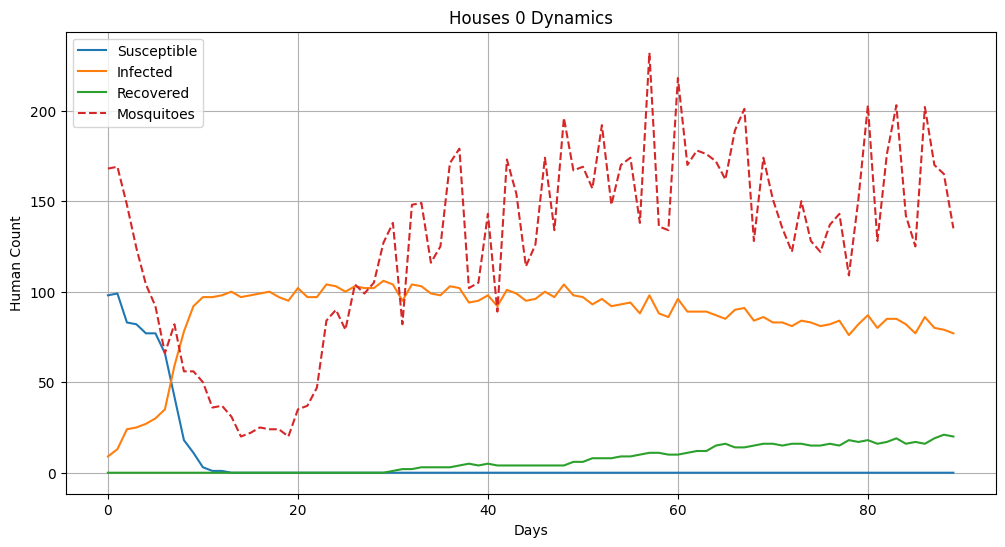

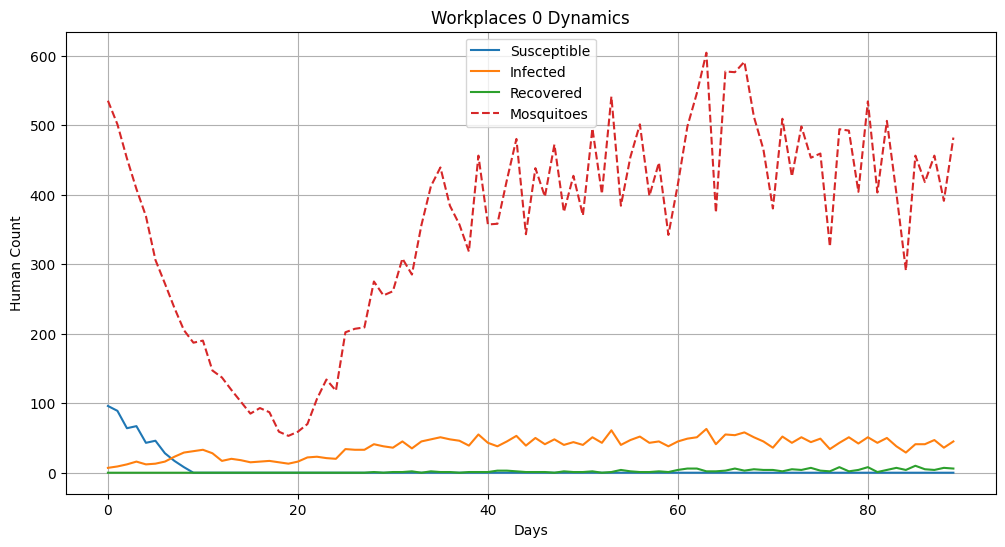

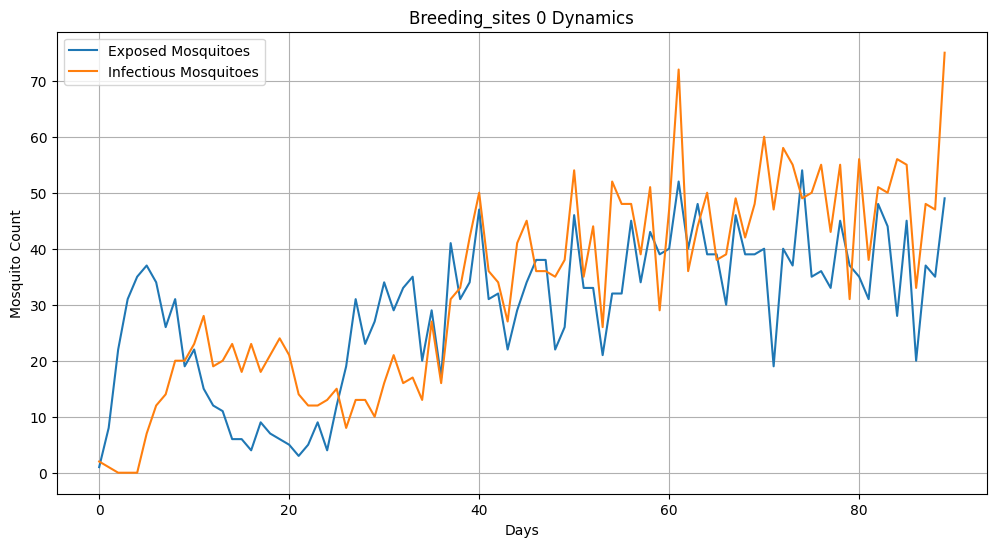

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Network:
    def __init__(self, name):
        self.name = name
        self.nodes = {}
        self.adjacency = {}
    
    def add_node(self, node_id):
        if node_id not in self.nodes:
            self.nodes[node_id] = set()
            self.adjacency[node_id] = []
    
    def connect_nodes(self, src, dest):
        if src in self.nodes and dest in self.nodes:
            self.adjacency[src].append(dest)
            self.adjacency[dest].append(src)
    
    def add_agent(self, node_id, agent_id):
        if node_id in self.nodes:
            self.nodes[node_id].add(agent_id)
    
    def remove_agent(self, node_id, agent_id):
        if node_id in self.nodes:
            self.nodes[node_id].discard(agent_id)
    
    def get_agents(self, node_id):
        return self.nodes.get(node_id, set())

class Human:
    def __init__(self, uid):
        self.id = uid
        self.state = 'S'
        self.home = None
        self.work = None
        self.current_location = None
        self.infected_day = -1
        self.age = random.randint(15, 60)
    
    def move(self, new_network, new_node):
        if self.current_location:
            old_net, old_node = self.current_location
            old_net.remove_agent(old_node, self.id)
        new_network.add_agent(new_node, self.id)
        self.current_location = (new_network, new_node)

class Mosquito:
    def __init__(self, uid):
        self.id = uid
        self.state = 'S'
        self.breeding_site = None
        self.current_location = None
        self.exposed_day = -1
        self.age = random.randint(1, 30)
    
    def move(self, new_network, new_node):
        if self.current_location:
            old_net, old_node = self.current_location
            old_net.remove_agent(old_node, self.id)
        new_network.add_agent(new_node, self.id)
        self.current_location = (new_network, new_node)

class MalariaSimulation:
    def __init__(self, temp=28):
        self.humans = []
        self.mosquitoes = []
        self.day = 0
        self.hour = 0
        
        # Initialize networks
        self.houses = Network("Houses")
        self.workplaces = Network("Workplaces")
        self.breeding_sites = Network("BreedingSites")
        
        # Create network nodes
        for i in range(100): self.houses.add_node(i)
        for i in range(20): self.workplaces.add_node(i)
        for i in range(50): self.breeding_sites.add_node(i)
        
        # Temperature parameters
        self.a = max(0, 0.017*temp - 0.165)
        self.b = 0.35/24
        self.c = 0.5/24
        self.r = 0.05/24
        self.mu_m = 1/(-0.03*(temp**2) + 1.31*temp - 4.4)
        self.tau_m = int(747.55*np.exp(-0.239*temp) + 5.06)
        self.mu_h = 0.0002
        
        # Initialize populations
        self.init_populations()
        
        # Tracking dictionaries
        self.global_history = {
            'S': [], 'I': [], 'R': [],
            'E_mos': [], 'I_mos': [],
            'total': []
        }
        
        self.location_history = {
            'houses': {n: {'S': [], 'I': [], 'R': [], 'mosquitoes': []} for n in self.houses.nodes},
            'workplaces': {n: {'S': [], 'I': [], 'R': [], 'mosquitoes': []} for n in self.workplaces.nodes},
            'breeding_sites': {n: {'E': [], 'I': []} for n in self.breeding_sites.nodes}
        }

    def init_populations(self):
        # Create humans
        for i in range(10000):
            human = Human(i)
            home = random.choice(list(self.houses.nodes))
            work = random.choice(list(self.workplaces.nodes))
            human.home = (self.houses, home)
            human.work = (self.workplaces, work)
            human.move(*human.home)
            if i < 10:
                human.state = 'I'
                human.infected_day = 0
            self.humans.append(human)
        
        # Create mosquitoes
        for i in range(50000):
            mosquito = Mosquito(1000 + i)
            site = random.choice(list(self.breeding_sites.nodes))
            mosquito.breeding_site = (self.breeding_sites, site)
            mosquito.move(*mosquito.breeding_site)
            if i < 100:
                mosquito.state = 'I'
            self.mosquitoes.append(mosquito)

    def schedule_movement(self):
        current_hour = self.hour % 24
        # Human movement
        for human in self.humans:
            if 8 <= current_hour < 18:
                if human.current_location != human.work:
                    human.move(*human.work)
            else:
                if human.current_location != human.home:
                    human.move(*human.home)
        
        # Mosquito movement
        for mosquito in self.mosquitoes:
            if random.random() < 0.1:
                if current_hour > 18 or current_hour < 6:
                    target_net = random.choice([self.houses, self.workplaces])
                    target_node = random.choice(list(target_net.nodes))
                else:
                    target_net = self.breeding_sites
                    target_node = random.choice(list(target_net.nodes))
                mosquito.move(target_net, target_node)

    def handle_infections(self):
        # Track human locations
        human_locs = defaultdict(list)
        for h in self.humans:
            net, node = h.current_location
            human_locs[(net.name, node)].append(h)
        
        # Check mosquito-human overlaps
        for m in self.mosquitoes:
            m_net, m_node = m.current_location
            key = (m_net.name, m_node)
            
            if key in human_locs:
                humans = human_locs[key]
                if m.state == 'I' and random.random() < self.a:
                    for h in humans:
                        if h.state == 'S' and random.random() < self.b:
                            h.state = 'I'
                            h.infected_day = self.day
                elif m.state == 'S':
                    infected = [h for h in humans if h.state == 'I']
                    if infected and random.random() < self.a * self.c:
                        m.state = 'E'
                        m.exposed_day = self.day

    def update_states(self):
        # Human updates
        new_humans = []
        for h in self.humans:
            if h.state == 'I' and (self.day - h.infected_day) > 14:
                if random.random() < self.r:
                    h.state = 'R'
            if random.random() < self.mu_h:
                if h.current_location:
                    net, node = h.current_location
                    net.remove_agent(node, h.id)
                continue
            new_humans.append(h)
        self.humans = new_humans
        
        # Mosquito updates
        new_mosquitoes = []
        for m in self.mosquitoes:
            if m.state == 'E' and (self.day - m.exposed_day) >= self.tau_m:
                m.state = 'I'
            if random.random() < self.mu_m:
                if m.current_location:
                    net, node = m.current_location
                    net.remove_agent(node, m.id)
                continue
            new_mosquitoes.append(m)
        
        # Repopulate mosquitoes
        while len(new_mosquitoes) < 5000:
            new_id = 1000 + len(new_mosquitoes)
            m = Mosquito(new_id)
            site = random.choice(list(self.breeding_sites.nodes))
            m.move(self.breeding_sites, site)
            new_mosquitoes.append(m)
        self.mosquitoes = new_mosquitoes

    def record_stats(self):
        # Global stats
        S = sum(1 for h in self.humans if h.state == 'S')
        I = sum(1 for h in self.humans if h.state == 'I')
        R = sum(1 for h in self.humans if h.state == 'R')
        E_mos = sum(1 for m in self.mosquitoes if m.state == 'E')
        I_mos = sum(1 for m in self.mosquitoes if m.state == 'I')
        
        self.global_history['S'].append(S)
        self.global_history['I'].append(I)
        self.global_history['R'].append(R)
        self.global_history['E_mos'].append(E_mos)
        self.global_history['I_mos'].append(I_mos)
        self.global_history['total'].append(len(self.humans))
        
        # Location-specific stats
        for net_type in ['houses', 'workplaces']:
            network = getattr(self, net_type)
            for node in network.nodes:
                agents = network.get_agents(node)
                humans = [h for h in self.humans if h.id in agents]
                mosquitoes = [m for m in self.mosquitoes if m.id in agents]
                
                self.location_history[net_type][node]['S'].append(
                    sum(1 for h in humans if h.state == 'S'))
                self.location_history[net_type][node]['I'].append(
                    sum(1 for h in humans if h.state == 'I'))
                self.location_history[net_type][node]['R'].append(
                    sum(1 for h in humans if h.state == 'R'))
                self.location_history[net_type][node]['mosquitoes'].append(len(mosquitoes))
        
        for node in self.breeding_sites.nodes:
            agents = self.breeding_sites.get_agents(node)
            mosquitoes = [m for m in self.mosquitoes if m.id in agents]
            
            self.location_history['breeding_sites'][node]['E'].append(
                sum(1 for m in mosquitoes if m.state == 'E'))
            self.location_history['breeding_sites'][node]['I'].append(
                sum(1 for m in mosquitoes if m.state == 'I'))

    def plot_global(self):
        days = np.arange(len(self.global_history['S']))
        plt.figure(figsize=(12,6))
        plt.plot(days, self.global_history['S'], label='Susceptible')
        plt.plot(days, self.global_history['I'], label='Infected')
        plt.plot(days, self.global_history['R'], label='Recovered')
        plt.xlabel('Days')
        plt.ylabel('Human Population')
        plt.legend()
        
        plt.twinx()
        plt.plot(days, self.global_history['E_mos'], '--', label='Exposed Mosquitoes')
        plt.plot(days, self.global_history['I_mos'], '-.', label='Infectious Mosquitoes')
        plt.ylabel('Mosquito Population')
        plt.legend()
        plt.title('Global Dynamics')
        plt.show()

    def plot_location(self, location_type, node_id):
        if location_type not in self.location_history:
            raise ValueError("Invalid location type")
        if node_id not in self.location_history[location_type]:
            raise ValueError("Invalid node ID")
        
        data = self.location_history[location_type][node_id]
        days = np.arange(len(data['S'])) if 'S' in data else np.arange(len(data['E']))
        
        plt.figure(figsize=(12,6))
        
        if location_type in ['houses', 'workplaces']:
            plt.plot(days, data['S'], label='Susceptible')
            plt.plot(days, data['I'], label='Infected')
            plt.plot(days, data['R'], label='Recovered')
            plt.plot(days, data['mosquitoes'], '--', label='Mosquitoes')
            plt.ylabel('Human Count')
        else:
            plt.plot(days, data['E'], label='Exposed Mosquitoes')
            plt.plot(days, data['I'], label='Infectious Mosquitoes')
            plt.ylabel('Mosquito Count')
        
        plt.xlabel('Days')
        plt.title(f'{location_type.capitalize()} {node_id} Dynamics')
        plt.legend()
        plt.grid(True)
        plt.show()

    def step(self):
        for _ in range(24):
            self.schedule_movement()
            self.handle_infections()
            self.hour += 1
        self.update_states()
        self.record_stats()
        self.day += 1

# Run simulation
sim = MalariaSimulation(temp=28)
for _ in range(90):
    sim.step()

# Plot results
sim.plot_global()
sim.plot_location('houses', 0)
sim.plot_location('workplaces', 0)
sim.plot_location('breeding_sites', 0)

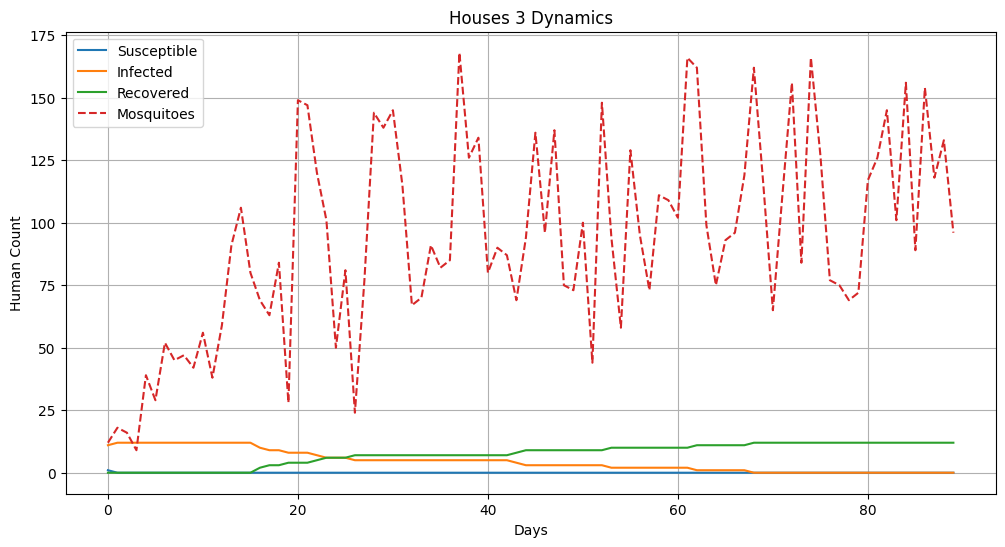

In [14]:
sim.plot_location('houses', 3)